In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/food-nutrition-dataset/food.csv
/kaggle/input/food-nutrition-dataset/food1.csv


In [2]:
!pip install torch torchvision pandas scikit-learn matplotlib

Epoch 1/50, Train Loss: 0.2669, Val Loss: 0.0861, Train Acc: 0.9465, Val Acc: 0.9858
Epoch 2/50, Train Loss: 0.0736, Val Loss: 0.0624, Train Acc: 0.9831, Val Acc: 0.9845
Epoch 3/50, Train Loss: 0.0610, Val Loss: 0.0589, Train Acc: 0.9880, Val Acc: 0.9818
Epoch 4/50, Train Loss: 0.0554, Val Loss: 0.0563, Train Acc: 0.9885, Val Acc: 0.9818
Epoch 5/50, Train Loss: 0.0523, Val Loss: 0.0504, Train Acc: 0.9897, Val Acc: 0.9879
Epoch 6/50, Train Loss: 0.0500, Val Loss: 0.0509, Train Acc: 0.9907, Val Acc: 0.9865
Epoch 7/50, Train Loss: 0.0480, Val Loss: 0.0519, Train Acc: 0.9894, Val Acc: 0.9825
Epoch 8/50, Train Loss: 0.0461, Val Loss: 0.0473, Train Acc: 0.9912, Val Acc: 0.9899
Epoch 9/50, Train Loss: 0.0449, Val Loss: 0.0501, Train Acc: 0.9916, Val Acc: 0.9825
Epoch 10/50, Train Loss: 0.0436, Val Loss: 0.0455, Train Acc: 0.9904, Val Acc: 0.9892
Epoch 11/50, Train Loss: 0.0419, Val Loss: 0.0451, Train Acc: 0.9906, Val Acc: 0.9885
Epoch 12/50, Train Loss: 0.0411, Val Loss: 0.0541, Train Acc: 0

/kaggle/working/classification_model.pth

/kaggle/working/regression_model.pth

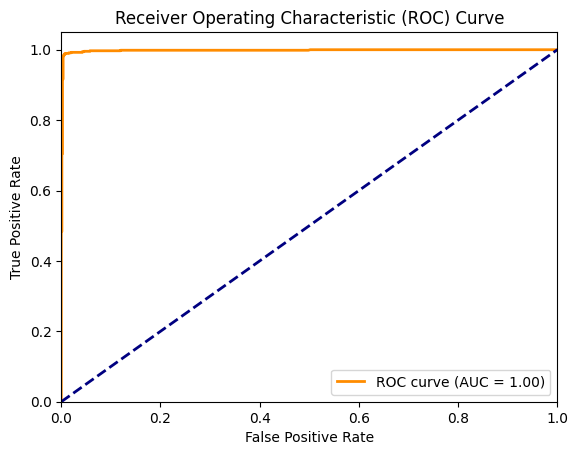

Diet Plan:
- VEGETABLE JUC COCKTAIL: 19 kcal, 0.63g protein, 0.09g fat, 4.55g carbs
- MIXED VEG & FRUIT JUC DRK: 29 kcal, 0.04g protein, 0.01g fat, 7.47g carbs
- GRAPEFRUIT: 30 kcal, 0.55g protein, 0.1g fat, 7.5g carbs
- FRUIT SALAD: 30 kcal, 0.35g protein, 0.07g fat, 7.87g carbs
- GRAPEFRUIT: 32 kcal, 0.63g protein, 0.1g fat, 8.19g carbs
- GRAPEFRUIT: 32 kcal, 0.63g protein, 0.1g fat, 8.08g carbs
- FRUIT COCKTAIL: 32 kcal, 0.42g protein, 0.05g fat, 8.51g carbs
- GRAPEFRUIT: 33 kcal, 0.69g protein, 0.1g fat, 8.41g carbs
- GRAPEFRUIT: 36 kcal, 0.58g protein, 0.1g fat, 9.15g carbs
- VEGETABLES: 36 kcal, 1.42g protein, 0.25g fat, 7.13g carbs
- GRAPEFRUIT: 37 kcal, 0.5g protein, 0.1g fat, 9.69g carbs
- GRAPEFRUIT: 37 kcal, 0.7g protein, 0.09g fat, 9.21g carbs
- GRAPEFRUIT: 37 kcal, 0.88g protein, 0.1g fat, 9.09g carbs
- FRUIT PUNCH-FLAVOR DRK: 37 kcal, 0.0g protein, 0.01g fat, 9.47g carbs
- VEGETABLES: 37 kcal, 1.4g protein, 0.2g fat, 7.31g carbs
- GRAPEFRUIT JUC: 38 kcal, 0.52g protein, 0

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import os
from IPython.display import FileLink

# Load dataset
data_path = "/kaggle/input/food-nutrition-dataset/food.csv"
df = pd.read_csv(data_path)

# Select relevant columns
df = df[['Category', 'Data.Kilocalories', 'Data.Protein', 'Data.Fat.Total Lipid', 'Data.Carbohydrate']].dropna()

# Convert nutritional columns to numeric and handle missing values
for col in ['Data.Kilocalories', 'Data.Protein', 'Data.Fat.Total Lipid', 'Data.Carbohydrate']:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

# Simulate binary classification (high vs. low calories, threshold=200 kcal)
df['label'] = (df['Data.Kilocalories'] > 200).astype(int)

# Features for calorie estimation
features = ['Data.Protein', 'Data.Fat.Total Lipid', 'Data.Carbohydrate']
X = df[features].values
y = df['label'].values
y_regression = df['Data.Kilocalories'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_regression, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train_reg = scaler.fit_transform(X_train_reg)
X_test_reg = scaler.transform(X_test_reg)

# Custom Dataset for PyTorch
class FoodDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = FoodDataset(X_train, y_train)
test_dataset = FoodDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

train_dataset_reg = FoodDataset(X_train_reg, y_train_reg)
test_dataset_reg = FoodDataset(X_test_reg, y_test_reg)
train_loader_reg = DataLoader(train_dataset_reg, batch_size=32, shuffle=True)
test_loader_reg = DataLoader(test_dataset_reg, batch_size=32, shuffle=False)

# Define the Model
class NutritionModel(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(NutritionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, 1)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize models
input_size = len(features)
classification_model = NutritionModel(input_size)
regression_model = NutritionModel(input_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classification_model.to(device)
regression_model.to(device)

# Function to compute accuracy for classification
def compute_accuracy(outputs, labels):
    predictions = (torch.sigmoid(outputs) >= 0.5).float()
    correct = (predictions == labels).float().sum()
    accuracy = correct / len(labels)
    return accuracy.item()

# Train model with early stopping and accuracy
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=50, patience=3, is_regression=False):
    model.train()
    best_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
            
            if not is_regression:
                train_correct += (torch.sigmoid(outputs) >= 0.5).float().eq(y_batch).sum().item()
                train_total += y_batch.size(0)
        
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accuracy = train_correct / train_total if not is_regression else 0
        train_accuracies.append(train_accuracy)
        
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch).squeeze()
                loss = criterion(outputs, y_batch)
                val_loss += loss.item() * X_batch.size(0)
                
                if not is_regression:
                    val_correct += (torch.sigmoid(outputs) >= 0.5).float().eq(y_batch).sum().item()
                    val_total += y_batch.size(0)
        
        val_loss /= len(test_loader.dataset)
        val_losses.append(val_loss)
        val_accuracy = val_correct / val_total if not is_regression else 0
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}" if not is_regression else
              f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered!")
                model.load_state_dict(best_model_state)
                break
    
    return train_losses, val_losses, train_accuracies, val_accuracies

# Train classification model
criterion_cls = nn.BCEWithLogitsLoss()
optimizer_cls = optim.Adam(classification_model.parameters(), lr=0.001)
train_losses_cls, val_losses_cls, train_accs_cls, val_accs_cls = train_model(
    classification_model, train_loader, test_loader, criterion_cls, optimizer_cls, patience=3)

# Train regression model
criterion_reg = nn.MSELoss()
optimizer_reg = optim.Adam(regression_model.parameters(), lr=0.001)
train_losses_reg, val_losses_reg, _, _ = train_model(
    regression_model, train_loader_reg, test_loader_reg, criterion_reg, optimizer_reg, patience=3, is_regression=True)

# Save models to Kaggle output directory
output_dir = "/kaggle/working/"
os.makedirs(output_dir, exist_ok=True)
classification_model_path = os.path.join(output_dir, "classification_model.pth")
regression_model_path = os.path.join(output_dir, "regression_model.pth")
torch.save(classification_model.state_dict(), classification_model_path)
torch.save(regression_model.state_dict(), regression_model_path)
print(f"Models saved to {classification_model_path} and {regression_model_path}")

# Generate download links
print("Click the links below to download the models:")
display(FileLink("classification_model.pth"))
display(FileLink("regression_model.pth"))

# Plot ROC Curve
def plot_roc_curve(model, test_loader):
    model.eval()
    y_true = []
    y_scores = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch).squeeze()
            y_scores.extend(torch.sigmoid(outputs).cpu().numpy())
            y_true.extend(y_batch.cpu().numpy())
    
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(classification_model, test_loader)

# Simulated Food Detection and Calorie Estimation
def estimate_calories(food_name, df, model, scaler):
    food_data = df[df['Category'].str.contains(food_name, case=False, na=False)]
    if food_data.empty:
        return "Food not found in dataset."
    
    features = food_data[['Data.Protein', 'Data.Fat.Total Lipid', 'Data.Carbohydrate']].values
    features = scaler.transform(features)
    features_tensor = torch.tensor(features, dtype=torch.float32).to(device)
    
    model.eval()
    with torch.no_grad():
        calories = model(features_tensor).squeeze().cpu().numpy()
    return np.mean(calories)

# Diet Planner
def generate_diet_plan(df, calorie_goal, preferences=None, allergies=None):
    available_foods = df.copy()
    if preferences:
        available_foods = available_foods[available_foods['Category'].str.contains('|'.join(preferences), case=False, na=False)]
    if allergies:
        available_foods = available_foods[~available_foods['Category'].str.contains('|'.join(allergies), case=False, na=False)]
    
    plan = []
    total_calories = 0
    available_foods = available_foods.sort_values('Data.Kilocalories')
    
    for _, row in available_foods.iterrows():
        if total_calories + row['Data.Kilocalories'] <= calorie_goal:
            plan.append({
                'food': row['Category'],
                'calories': row['Data.Kilocalories'],
                'protein': row['Data.Protein'],
                'fat': row['Data.Fat.Total Lipid'],
                'carbohydrate': row['Data.Carbohydrate']
            })
            total_calories += row['Data.Kilocalories']
    
    return plan, total_calories

# Example usage
calorie_goal = 2000
preferences = ['VEGETABLE', 'FRUIT']
allergies = ['PEANUT']
diet_plan, total_calories = generate_diet_plan(df, calorie_goal, preferences, allergies)

print("Diet Plan:")
for item in diet_plan:
    print(f"- {item['food']}: {item['calories']} kcal, {item['protein']}g protein, {item['fat']}g fat, {item['carbohydrate']}g carbs")
print(f"Total Calories: {total_calories} kcal")

# Example calorie estimation
food_name = "apple"
calorie_estimate = estimate_calories(food_name, df, regression_model, scaler)
print(f"Estimated calories for {food_name}: {calorie_estimate:.2f} kcal")